In [1]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.special
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import sklearn

import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import shap
import joblib
from sklearn import metrics


# XGBoost Model to predict returns
to do
 - Do test for 3 month return as well


In [2]:
tmp_df = pd.read_csv('../data/VQ_data.csv')
tmp_df['d'] = pd.to_datetime(tmp_df['d'])
tmp_df = tmp_df.set_index(['d', 'insID'])

In [47]:
min_MCAP = 500
clean_df = tmp_df[tmp_df['MCAP']>min_MCAP]
horizon = 3 #what tiem frame are we predicting
N_GROUP = 2

monthly_df =clean_df.groupby([clean_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
monthly_df['ret'] = monthly_df['adj_c'].groupby(level='insID').apply(lambda x: x.shift(- horizon)/x)

monthly_df = monthly_df.unstack('insID').iloc[::horizon, :].stack('insID')
#Take rank of log ret per month values! Ranking forces it into a stationary distribution!!
monthly_df['rank_ret'] = monthly_df['ret'].groupby(level='d').rank(ascending=False)



#### CLEAN DATA


colmax_list = ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']

#set inf values to max
for col in colmax_list:
    m = monthly_df.loc[monthly_df[col] != np.inf, :].max()
    monthly_df.replace(np.inf,m,inplace=True)



#Invesrt the values that should be low so they should be high
for colmax in colmax_list:
    monthly_df.loc[:, colmax] = (1/monthly_df[colmax])
    
### INDICATOR FUNCTION IF THE COMPANY IS IN FINANCE & RE
monthly_df['sector_ind'] = 0
monthly_df.loc[monthly_df['sector'] == 'finance_RE','sector_ind' ] = 1


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [48]:
col_list = monthly_df.columns.to_list()

for ele in ['c','number_Of_Shares', '1_day_ret','Name','volatility_60day',
                 'sector','market', 'acceleration', 'adj_mom', 'sharpe', 'ret','adj_c', 'EA_ret', 'sector_ind']:
    try:
        col_list.remove(ele)
    except:
        print(ele)


col_list1 = col_list.copy()
col_list1.append('rank_ret')


zscore_df = pd.DataFrame()
zscore_df.index = monthly_df.index

for col in col_list1:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = monthly_df[col]
    zscore_tmp_df = zscore_tmp_df.dropna()
    #Rank for each day!! This makes it robust and stationary!! 
    
    # HIGH VALUE GIVES LOW RANK!!!
    zscore_tmp_df = zscore_tmp_df.groupby(level='d').rank(ascending=False)
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()


model_list = []
for col in zscore_df.columns:
    x = re.search('zscore$', col)
    if(x!=None):
        model_list.append(col)

#group by quintiles 


zscore_df['rank_ret_group'] = pd.qcut(zscore_df['rank_ret_zscore'].rank(method='first'), N_GROUP, labels = range(0, N_GROUP))
zscore_df['rank_ret_group'] = zscore_df['rank_ret_group'].astype('category')
#Add indicator function for sector
sector_id_df = pd.DataFrame(monthly_df['sector_ind'])
zscore_df = zscore_df.merge(sector_id_df, on=['d','insID'],how='left')


In [49]:

##############################################    
#combined measures, redo z scores and groups!!
##############################################

zscore_df['comb_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore']
zscore_df['ear_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore'] + zscore_df['EAR_std_zscore']
zscore_df['val_comp'] = zscore_df['PE_zscore'] + zscore_df['PB_zscore'] +zscore_df['EVEBIT_zscore'] +zscore_df['PFCF_zscore']+zscore_df['PS_zscore']
zscore_df['qual_comp'] = zscore_df['GPA_zscore'] + zscore_df['ROIC_zscore'] +zscore_df['ROE_zscore'] + zscore_df['AT_zscore']+zscore_df['FCFROE_zscore'] + zscore_df['Asset_growth_zscore']


## REDO ZSCORE AND QUANTILES FOR COMBINED MEASURES

for col in ['comb_mom', 'ear_mom', 'val_comp', 'qual_comp']:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = zscore_df[col]
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

##############################################    
######### REDO FOR COMBINATION OF COMBINATIONS, VMQ, QM, VQ, VM
#################################################

zscore_df['VMQ'] = zscore_df['ear_mom_zscore'] + zscore_df['val_comp_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['MQ'] = zscore_df['ear_mom_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['VQ'] =  zscore_df['val_comp_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['VM'] = zscore_df['ear_mom_zscore'] + zscore_df['val_comp_zscore']

## REDO ZSCORE AND QUANTILES FOR COMBINED OF COMBINED MEASURES

for col in ['VMQ', 'MQ', 'VQ', 'VM']:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = zscore_df[col]
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()


    
full_df_tmp = zscore_df.copy()
zscore_df = zscore_df.unstack('insID').iloc[::horizon, :].stack('insID')

# Horizon Forward Return

### Train Model

In [73]:
model_list = []
for col in zscore_df.columns:
    x = re.search('zscore$', col)
    if(x!=None):
        model_list.append(col)
        

coeff_list = model_list.copy()

remv_list = ['rank_ret_zscore', 'ear_mom_zscore', 'val_comp_zscore','qual_comp_zscore', 'comb_mom_zscore',
            'MQ_zscore', 'VM_zscore', 'VQ_zscore', 'VMQ_zscore',
            'mom1_zscore', 'ROE_chg_zscore',
             'rev_growth_zscore','EPS_growth_zscore','EPS_acceleration_zscore','MA50_VOL_zscore']

for ele in remv_list:
    coeff_list.remove(ele)
        

In [74]:
coeff_list

['MCAP_zscore',
 'PE_zscore',
 'GPA_zscore',
 'GPA_chg_zscore',
 'Asset_growth_zscore',
 'PB_zscore',
 'EAR_std_zscore',
 'AVG_EAR_zscore',
 'EVEBIT_zscore',
 'EVFCF_zscore',
 'ROIC_zscore',
 'ROE_zscore',
 'AT_zscore',
 'RSURP_Y_zscore',
 'SUE_Y_zscore',
 'mom12_zscore',
 'mom6_zscore',
 'mom3_zscore',
 'volatility_zscore',
 'sharpe_6m_zscore',
 'high_12m_zscore',
 'high_6m_zscore',
 'high_3m_zscore',
 'high_1m_zscore',
 'high_2y_zscore',
 'high_3y_zscore',
 'high_4y_zscore',
 'low_1m_zscore',
 'low_3m_zscore',
 'low_6m_zscore',
 'low_12m_zscore',
 'low_2y_zscore',
 'skew_zscore',
 'EMA_32_96_zscore',
 'EMA_96_288_zscore',
 'range_2y_zscore',
 'range_12m_zscore',
 'range_6m_zscore',
 'range_3m_zscore',
 'range_1m_zscore',
 'VAR_1_zscore',
 'FCFROE_zscore',
 'ROA_zscore',
 'PS_zscore',
 'PFCF_zscore',
 'DIV_Y_zscore',
 'res_mom12_zscore',
 'Gross_margin_zscore',
 'beta_zscore',
 'alpha_zscore',
 'std_alpha_zscore',
 'ido_mom12_zscore']

In [87]:
mom_coeff = ['mom12_zscore', 'mom6_zscore', 'mom3_zscore']
coeff_list = ['high_12m_zscore','high_6m_zscore','high_3m_zscore',
              'high_1m_zscore','high_2y_zscore','high_3y_zscore','high_4y_zscore']

#coeff_list = ['mom12_zscore', 'EAR_std_zscore','mom6_zscore','mom3_zscore', 'volatility_zscore']

#coeff_list = ['ear_mom_zscore','val_comp_zscore','qual_comp_zscore', 'VMQ_zscore']


In [88]:
np.random.seed(123)
train_ratio = 0.7

reg_df = zscore_df[coeff_list + ['rank_ret_group']].dropna()



eval_train_df = reg_df[:int(len(reg_df)*train_ratio)]
eval_test_df =  reg_df[int(len(reg_df)*(1-train_ratio)):]

X_ml = reg_df[coeff_list]
Y_ml = reg_df[['rank_ret_group']].values.ravel().astype(int)

#splitting data into train and test
X_train = X_ml[:int(len(X_ml)*train_ratio)]
X_test = X_ml[int(len(X_ml)*(1-train_ratio)):]
Y_train = Y_ml[:int(len(X_ml)*(train_ratio))]
Y_test = Y_ml[int(len(X_ml)*(1-train_ratio)):]


In [89]:
params = { 'max_depth': [1],
           'learning_rate': [0.01, 0.02, 0.03, 0.04],
           'n_estimators': [30,50,60],
           'colsample_bytree': [ 0.1,0.2,0.3 ]}

In [90]:
## TUNE WITH GRIDSEARCH

xgbr = xgb.XGBClassifier(seed = 20, eval_metric = 'mlogloss',  use_label_encoder=False)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params ,
                   verbose=1)
clf.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_la

In [91]:
clf.best_params_

{'colsample_bytree': 0.1,
 'learning_rate': 0.01,
 'max_depth': 1,
 'n_estimators': 50}

### Model Eval


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


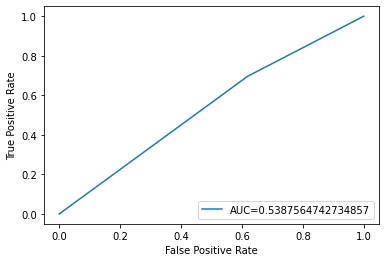

In [92]:
VIP_df = pd.DataFrame(clf.best_estimator_.feature_importances_, index = X_train.columns).sort_values(0, ascending=True)
eval_train_df.loc[:, 'pred_y'] = clf.predict(X_train)
eval_train_df.loc[:,'ret'] = monthly_df['ret']

train_res_df = pd.DataFrame()
train_res_df.loc[:,'Return By Pred G'] = eval_train_df.groupby('pred_y').mean()['ret']
train_res_df.loc[:,'Return By Real G'] = eval_train_df.groupby('rank_ret_group').mean()['ret']



fpr, tpr, _ = metrics.roc_curve(eval_train_df['rank_ret_group'].values.astype(int),
                                eval_train_df['pred_y'].values.astype(int))

auc = metrics.roc_auc_score(eval_train_df['rank_ret_group'].values.astype(int),
                                eval_train_df['pred_y'].values.astype(int))

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [93]:
train_res_df

,Return By Pred G,Return By Real G
pred_y,,
0,1.026060,0.934404
1,1.050661,1.148477


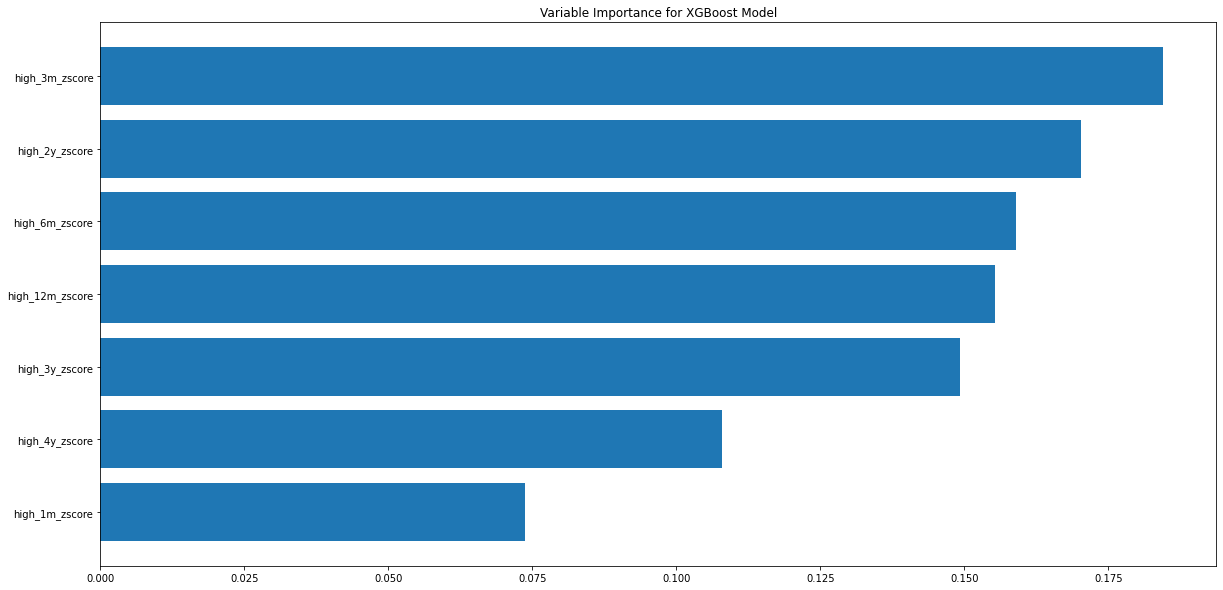

In [94]:
plt.figure(figsize=(20,10));
plt.barh(VIP_df.transpose().columns,VIP_df.iloc[:, 0]);
plt.title('Variable Importance for XGBoost Model');

## SHAPS

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


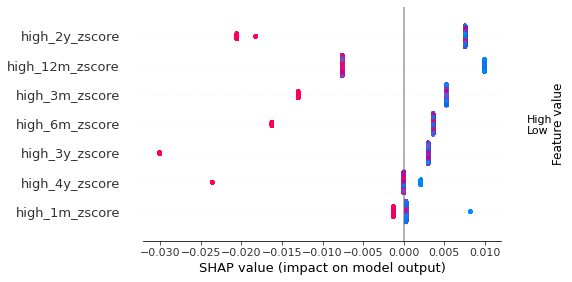

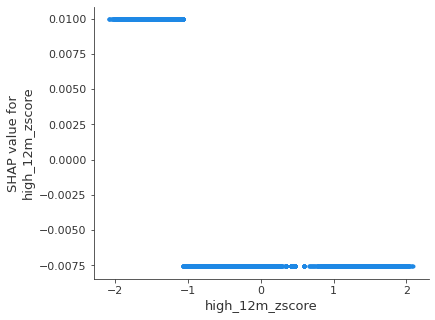

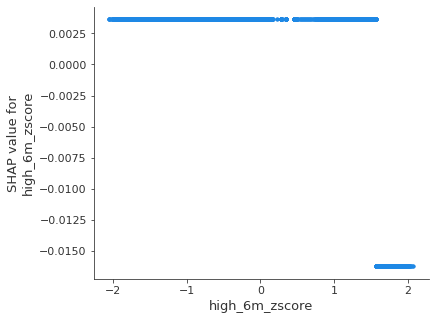

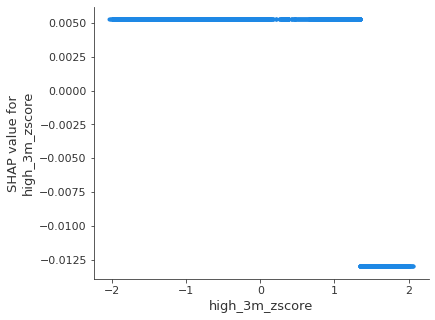

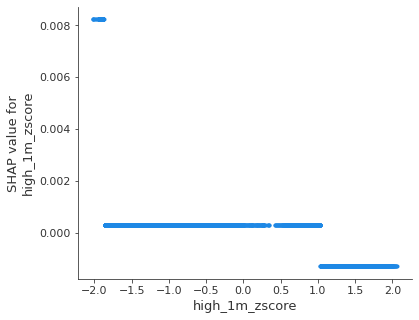

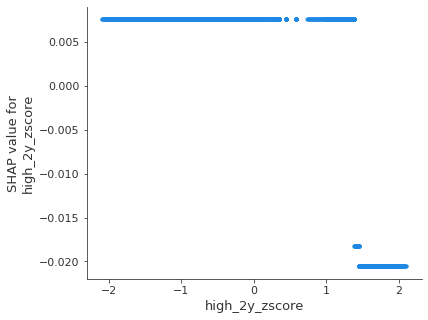

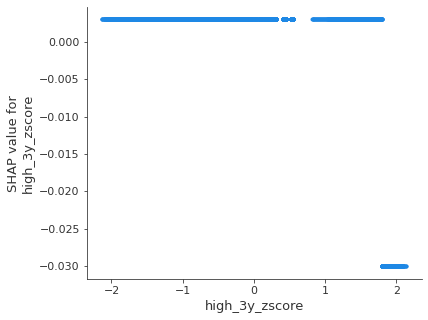

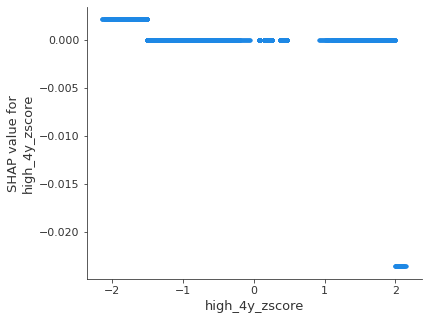

In [95]:

# compute SHAP values
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_ml)


shap.summary_plot(shap_values,X_ml)
for var in coeff_list:
    shap.dependence_plot(var, shap_values, X_ml, interaction_index=None) #, interaction_index=None
    

## BACKTEST

## Eval test Set

In [61]:
eval_test_df.loc[:,'ret'] = monthly_df['ret']
eval_test_df.loc[:, 'pred_y'] = clf.predict(X_test)

test_res_df = pd.DataFrame()
test_res_df.loc[:,'Return By Pred G'] = eval_test_df.groupby('pred_y').mean()['ret']
test_res_df.loc[:,'Return By Real G'] = eval_test_df.groupby('rank_ret_group').mean()['ret']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
test_res_df

,Return By Pred G,Return By Real G
pred_y,,
0,1.026364,0.908656
1,1.051263,1.167563


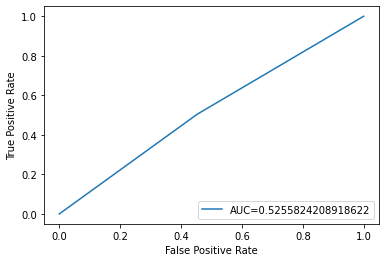

In [63]:
fpr, tpr, _ = metrics.roc_curve(eval_test_df['rank_ret_group'].values.astype(int),
                                eval_test_df['pred_y'].values.astype(int))

auc = metrics.roc_auc_score(eval_test_df['rank_ret_group'].values.astype(int),
                                eval_test_df['pred_y'].values.astype(int))

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()